# 1- NYC Property EDA

## Initial Exploration

In [56]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

In [57]:
# !ls gdrive/Othercomputers/'My Mac'/'Fall 2023'/BA810/Project/nyc-rolling-sales.csv

In [58]:
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint

# Import necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv # needed to enable Halving features
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [59]:
import pandas as pd
nyc = pd.read_csv('https://raw.githubusercontent.com/eshentong/BA810-team-project/main/nyc-rolling-sales.csv')

In [60]:
print(nyc.shape)
nyc

(84548, 22)


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


### What's up with the first column?

The first column is unnamed.

These values appear to have been used to iterate through each borough's properties. We will simply drop this column.

In [61]:
nyc.drop(columns={nyc.columns[0]}, inplace=True)

### EASE-MENT column

In [62]:
nyc['EASE-MENT'].unique()

array([' '], dtype=object)

EASE-MENT is an empty column so we will remove it as well.

In [63]:
nyc.drop(columns={'EASE-MENT'}, inplace=True)

### Column Wise Exploration

From [Kaggle](https://www.kaggle.com/datasets/new-york-city/nyc-property-sales/data):

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

**BOROUGH**: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

**BLOCK; LOT**: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a **BBL**.

**BUILDING CLASS AT PRESENT** and **BUILDING CLASS AT TIME OF SALE**: The type of building at various points in time. See the glossary linked to below.

For further reference on individual fields see the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf). For the building classification codes see the [Building Classifications Glossary](https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html).

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.

This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.

In [64]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       84548 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                84548 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

#### Setting the right dtypes

In [65]:
# Converting to categorical columns

col_to_cat = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']
for col in col_to_cat:
   nyc[col] = nyc[col].astype('category')

In [66]:
# Converting to numerical columns

col_to_numeric = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE', 'YEAR BUILT']
for col in col_to_numeric:
  nyc[col] = pd.to_numeric(nyc[col], errors='coerce')

In [67]:
# Converting to datetime column
nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])

In [68]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING CLASS CATEGORY         84548 non-null  category      
 3   TAX CLASS AT PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING CLASS AT PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT NUMBER                84548 non-null  object        
 9   ZIP CODE                        84548 non-null  category      
 10  RESIDENTIAL UNITS               84548 non-null  int64         
 11  CO

## Missing Values Exploration

According to .info(), there are missing values in the following columns: **LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE**

We also know from manual observation that there are some missing values in the following columns: **APARTMENT NUMBER**

In [69]:
print('% missing for LAND SQUARE FEET:', round(nyc['LAND SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for GROSS SQUARE FEET:', round(nyc['GROSS SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for SALE PRICE:', round(nyc['SALE PRICE'].isna().sum()/nyc.shape[0], 2))

% missing for LAND SQUARE FEET: 0.31
% missing for GROSS SQUARE FEET: 0.33
% missing for SALE PRICE: 0.17


In [70]:
nyc['SALE PRICE'].value_counts()

0.00          10228
10.00           766
450000.00       427
550000.00       416
650000.00       414
              ...  
191100.00         1
811000.00         1
782990.00         1
2784765.00        1
69300.00          1
Name: SALE PRICE, Length: 10007, dtype: int64

Apart from the missing values in 'SALE PRICE' column, there are also 10994 values in the column which the value equals either 0 (10228) or 10 (766).

In [71]:
nyc['APARTMENT NUMBER'].value_counts()

        65496
4         298
3A        295
2         275
3B        275
        ...  
ST50        1
ST54        1
SU13        1
SU21        1
363         1
Name: APARTMENT NUMBER, Length: 3989, dtype: int64

For Apartment Number, there are 65496 empty columns. We will assume that these are empty since this is the sale of a whole building rather than an apartment.

### Summary Statistics

In [72]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

nyc.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,84548.00,84548.00,84548.00,58296.00,56936.00,84548.00,69987.00
mean,2.03,0.19,2.25,3941.68,4045.71,1789.32,1276456.50
std,16.72,8.71,18.97,41983.97,35032.49,537.34,11405255.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,1650.00,1046.75,1920.00,225000.00
50%,1.00,0.00,1.00,2325.00,1680.00,1940.00,530000.00
75%,2.00,0.00,2.00,3500.00,2560.00,1965.00,950000.00
max,1844.00,2261.00,2261.00,4252327.00,3750565.00,2017.00,2210000000.00


In [73]:
nyc.describe(include=['category', 'object'])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548
unique,5,254,47,11,11566,2627,167,67563,3989,186,4,166
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,5066,1,D4,131-05 40TH ROAD,,10314,1,R4
freq,26736,3068,18235,38633,404,4125,12663,210,65496,1687,41533,12989


In [74]:
nyc.describe(include = 'datetime')

<ipython-input-74-2e89c4609a0d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nyc.describe(include = 'datetime')


,SALE DATE
count,84548
unique,364
top,2017-06-29 00:00:00
freq,544
first,2016-09-01 00:00:00
last,2017-08-31 00:00:00


### Visualizations for the Report

In [75]:
spd = nyc[['SALE PRICE']].copy()

In [76]:
spd

,SALE PRICE
0,6625000.00
1,NaN
2,NaN
3,3936272.00
4,8000000.00
...,...
84543,450000.00
84544,550000.00
84545,460000.00
84546,11693337.00


In [77]:
# nyc = nyc[(nyc['SALE PRICE'] != 0) & (nyc['SALE PRICE'] != 10) & (~nyc['SALE PRICE'].isnull())]
spd = spd[(spd['SALE PRICE'] != 0) & (spd['SALE PRICE'] != 10) & (spd['SALE PRICE'].notna())]
spd

,SALE PRICE
0,6625000.00
3,3936272.00
4,8000000.00
6,3192840.00
9,16232000.00
...,...
84543,450000.00
84544,550000.00
84545,460000.00
84546,11693337.00


There are a lot of outliers. Let me handle those before making the visualizations.

In [78]:
spd = spd[spd['SALE PRICE'] < 5000000]

<Figure size 3000x1000 with 0 Axes>

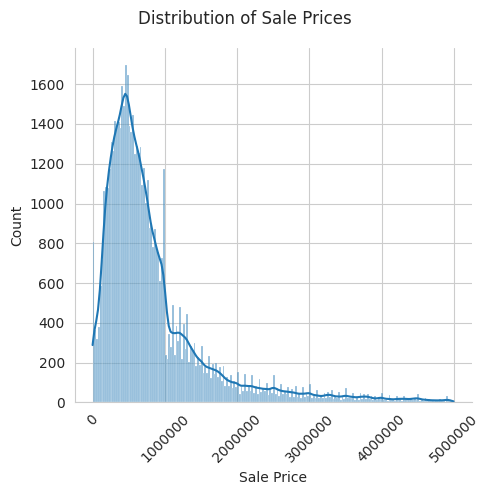

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(30, 10))

dplot = sns.displot(data=spd, x='SALE PRICE', bins=200, kde=True, kde_kws={'bw_adjust': 0.5})

dplot.set_axis_labels("Sale Price", "Count")
dplot.fig.suptitle("Distribution of Sale Prices")
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show();

## 1. Data Cleaning

In [80]:
nyc_copy= nyc.copy()

- Standardizing column names


In [81]:
nyc_copy.columns = nyc_copy.columns.str.replace(' ', '_')

In [82]:
# Riya's Part
temp = pd.DataFrame(index=nyc_copy.columns)
temp

""
BOROUGH
NEIGHBORHOOD
BUILDING_CLASS_CATEGORY
TAX_CLASS_AT_PRESENT
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT
ADDRESS
APARTMENT_NUMBER
ZIP_CODE


- Checking for null values

In [83]:
def nyc_df_info():
    temp = pd.DataFrame(index=nyc_copy.columns)
    temp["Datatype"] = nyc_copy.dtypes
    temp["Not null values"] = nyc_copy.count()
    temp["Null values"] = nyc_copy.isnull().sum()
    temp["Percentage of Null values"] = (nyc_copy.isnull().mean())*100
    temp["Unique count"] = nyc_copy.nunique()
    return temp
nyc_df_info()

,Datatype,Not null values,Null values,Percentage of Null values,Unique count
BOROUGH,category,84548,0,0.00,5
NEIGHBORHOOD,category,84548,0,0.00,254
BUILDING_CLASS_CATEGORY,category,84548,0,0.00,47
TAX_CLASS_AT_PRESENT,category,84548,0,0.00,11
BLOCK,category,84548,0,0.00,11566
LOT,category,84548,0,0.00,2627
BUILDING_CLASS_AT_PRESENT,category,84548,0,0.00,167
ADDRESS,object,84548,0,0.00,67563
APARTMENT_NUMBER,object,84548,0,0.00,3989
ZIP_CODE,category,84548,0,0.00,186


In [84]:
nyc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING_CLASS_CATEGORY         84548 non-null  category      
 3   TAX_CLASS_AT_PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING_CLASS_AT_PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT_NUMBER                84548 non-null  object        
 9   ZIP_CODE                        84548 non-null  category      
 10  RESIDENTIAL_UNITS               84548 non-null  int64         
 11  CO

In [85]:
#deeper investigation of all columns
nyc_copy['LAND_SQUARE_FEET'].isnull().sum()

26252

###EXPLORE MORE COLS, MAYBE TAKE IT FROM SECTION ABOVE

In [86]:
nyc_copy['LAND_SQUARE_FEET'].replace('-', np.nan, inplace=True)

-Dropping irrelevant columns:
- `ADDRESS`, `BLOCK`, `LOT`, `APARTMENT_NUMBER`
- `BUILDING_CLASS_CATEGORY`, `TAX_CLASS_AT_PRESENT`, `BUILDING_CLASS_AT_PRESENT`

In [89]:
#due to one-hard encoding, these cols are too granular
columns_to_drop = ['ADDRESS', 'BLOCK', 'LOT', 'APARTMENT_NUMBER', \
                                'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', ]
nyc_copy.drop(columns=columns_to_drop, inplace=True)
nyc_copy

,BOROUGH,NEIGHBORHOOD,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,ALPHABET CITY,10009,5,0,5,1633.00,6440.00,1900,2,C2,6625000.00,2017-07-19
1,1,ALPHABET CITY,10009,28,3,31,4616.00,18690.00,1900,2,C7,NaN,2016-12-14
2,1,ALPHABET CITY,10009,16,1,17,2212.00,7803.00,1900,2,C7,NaN,2016-12-09
3,1,ALPHABET CITY,10009,10,0,10,2272.00,6794.00,1913,2,C4,3936272.00,2016-09-23
4,1,ALPHABET CITY,10009,6,0,6,2369.00,4615.00,1900,2,C2,8000000.00,2016-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,10309,2,0,2,2400.00,2575.00,1998,1,B9,450000.00,2016-11-28
84544,5,WOODROW,10309,2,0,2,2498.00,2377.00,1998,1,B9,550000.00,2017-04-21
84545,5,WOODROW,10309,2,0,2,4000.00,1496.00,1925,1,B2,460000.00,2017-07-05
84546,5,WOODROW,10309,0,7,7,208033.00,64117.00,2001,4,K6,11693337.00,2016-12-21


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

cat_attribs = ['BOROUGH', 'NEIGHBORHOOD',  'ZIP_CODE', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
num_attribs = ['SALE_DATE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(drop='first'))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False)
prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f204bab7f10>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f204bab71c0>)],
                  verbose_feature_names_out=False)

- Numeric columns

In [93]:
numeric_data = nyc_copy[num_attribs]

# nyc_num_stand = pd.DataFrame(standarized_data, columns=numeric_columns)
# nyc_num_stand